In [56]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

In [2]:
# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

In [3]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [4]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [5]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()
    
    for i, j in m.movies_df.iterrows():
        j["Character"] = c.map(j["Character"])

    return c,m

c, m = preprocessing()

In [6]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False)

,Character,Sentence,Movie
41,Harry,1028,1028
78,Ron,536,536
44,Hermione,485,485
40,Hagrid,394,394
21,Dumbledore,239,239
...,...,...,...
86,Slytherins,1,1
13,Cornish Pixies,1,1
69,Parvati,1,1
70,Penelope Clearwater,1,1


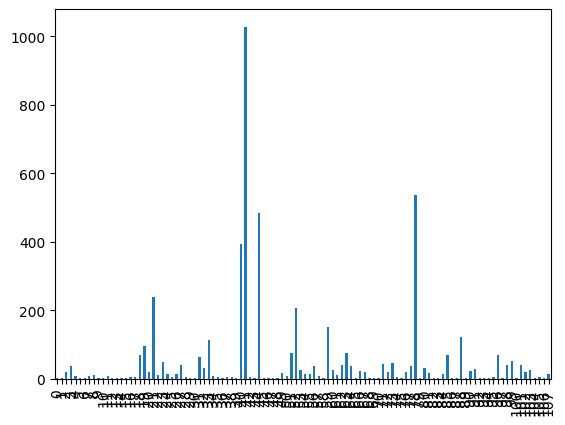

In [7]:
# create histograms for length of total script
def plotLengethOfTotalScript(df):
    # grouped.plot(kind='bar')
    pd.Series(grouped["Sentence"]).plot(kind='bar')

plotLengethOfTotalScript(m.movies_df)

In [ ]:
# Combine sentences for each character
combined_sentences = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

In [103]:

combined_sentences['vocabulary'] = None
combined_sentences['vocabulary_size'] = None
combined_sentences['words_mentioned_once'] = None
combined_sentences['most_frequent_words'] = None


for index, row in combined_sentences.iterrows():
    character = row['Character']
    sentences = row['Sentence']
    words = nltk.word_tokenize(sentences)
    
    # Calculate vocabulary size (total unique words)
    vocabulary_size = len(set(words))

    # Create a vocabulary (set of unique words)
    vocabulary = set(words)

    # Convert the set back to a sorted list if needed
    vocabulary_list = sorted(list(vocabulary))

    combined_sentences.at[index, 'vocabulary']=vocabulary_list

    # row['vocabulary_size']==vocabulary_size
    combined_sentences.at[index, 'vocabulary_size'] = vocabulary_size

    # Create a word frequency dictionary
    word_frequency = Counter(words)

    # Find words mentioned only once
    words_mentioned_once = [word for word, freq in word_frequency.items() if freq == 1]
    combined_sentences.at[index, 'words_mentioned_once']=words_mentioned_once

    # Find the thirty most frequent words
    most_frequent_words_list = word_frequency.most_common(30)
    # Extract the words from the list of tuples
    most_frequent_words = [word for word, count in most_frequent_words_list]
    combined_sentences.at[index, 'most_frequent_words']=most_frequent_words
    # print(vocabulary_size, words_mentioned_once, most_frequent_words[0])

#Display the result
print(combined_sentences['words_mentioned_once'])
print(combined_sentences['vocabulary'])

0                                        [AHHHHHHH, YAY]
1         [We, know, about, the, Sorcerer, 's, Stone, !]
2      [Who, Is, that, you, Yes, has, sent, men, holl...
3      [still, here, 'yes, in, ungrateful, way, Damn,...
4      [Not, now, Pupkins, For, when, Masons, arrive,...
                             ...                        
103    [Use, boy, He, Let, speak, strength, this, Pot...
104                                   [Harry, Potter, ?]
105    [Doris, Crockford, Mr, Potter, ca, n't, believ...
106           [Anything, off, the, trolley, ,, dears, ?]
107    [spent, summer, devising, whole, program, gon,...
Name: words_mentioned_once, Length: 108, dtype: object
0                                     [!, AHHHHHHH, YAY]
1         [!, 's, Sorcerer, Stone, We, about, know, the]
2      ['s, ,, ., ?, But, Chamber, Go, Goodbye, Hagri...
3      [!, ', 'd, 's, 'yes, ,, ., ..., 12, ?, A, Actu...
4      [!, ,, ., For, Harry, He, How, Marge, Masons, ...
                             ... 

In [97]:
def characterToCharacterMatrix(characters, word_lists):
    text = [" ".join(word_list) for word_list in word_lists]
    # Initialize a CountVectorizer to convert text to a bag of words
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    similarity_matrix = []


    ##Similarity
    for i in range(len(character_names)):
        row = []
        for j in range(len(character_names)):
            if i == j:
                similarity = 1.0  # Similarity with oneself is 1.0
            else:
                set1 = set(X[i].indices)
                set2 = set(X[j].indices)
                intersection = len(set1.intersection(set2))
                union = len(set1) + len(set2) - intersection
                similarity = intersection / union
            row.append(similarity)
        similarity_matrix.append(row)


    #Matrix
    similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)
    
    # Plot the character-to-character matrix
    plt.figure(figsize=(25, 25))
    plt.imshow(similarity_df, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(character_names)), character_names, rotation=45)
    plt.yticks(range(len(character_names)), character_names)
    plt.title('Character-to-Character Matrix')
    plt.show()
    
    # Display the similarity matrix
    print(similarity_df)

    return similarity_df

In [99]:
def mostCommonPairs(characters, matrix) :
    character_names = characters.tolist()
    most_common_pairs = []
    for character1 in character_names:
        for character2 in character_names:
            if character1 != character2:
                count = similarity_df.at[character1, character2]
                most_common_pairs.append((character1, character2, count))
    
    # Sort the list of pairs by count in descending order
    most_common_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Display the most common pairs
    print("Most Common Pairs:")
    # for pair in most_common_pairs:
    #     print(f"{pair[0]} and {pair[1]}: {pair[2]} common words")
    
    for x in range(30):
        print(f"{most_common_pairs[x][0]} and {most_common_pairs[x][1]}: {most_common_pairs[x][2]} common words")

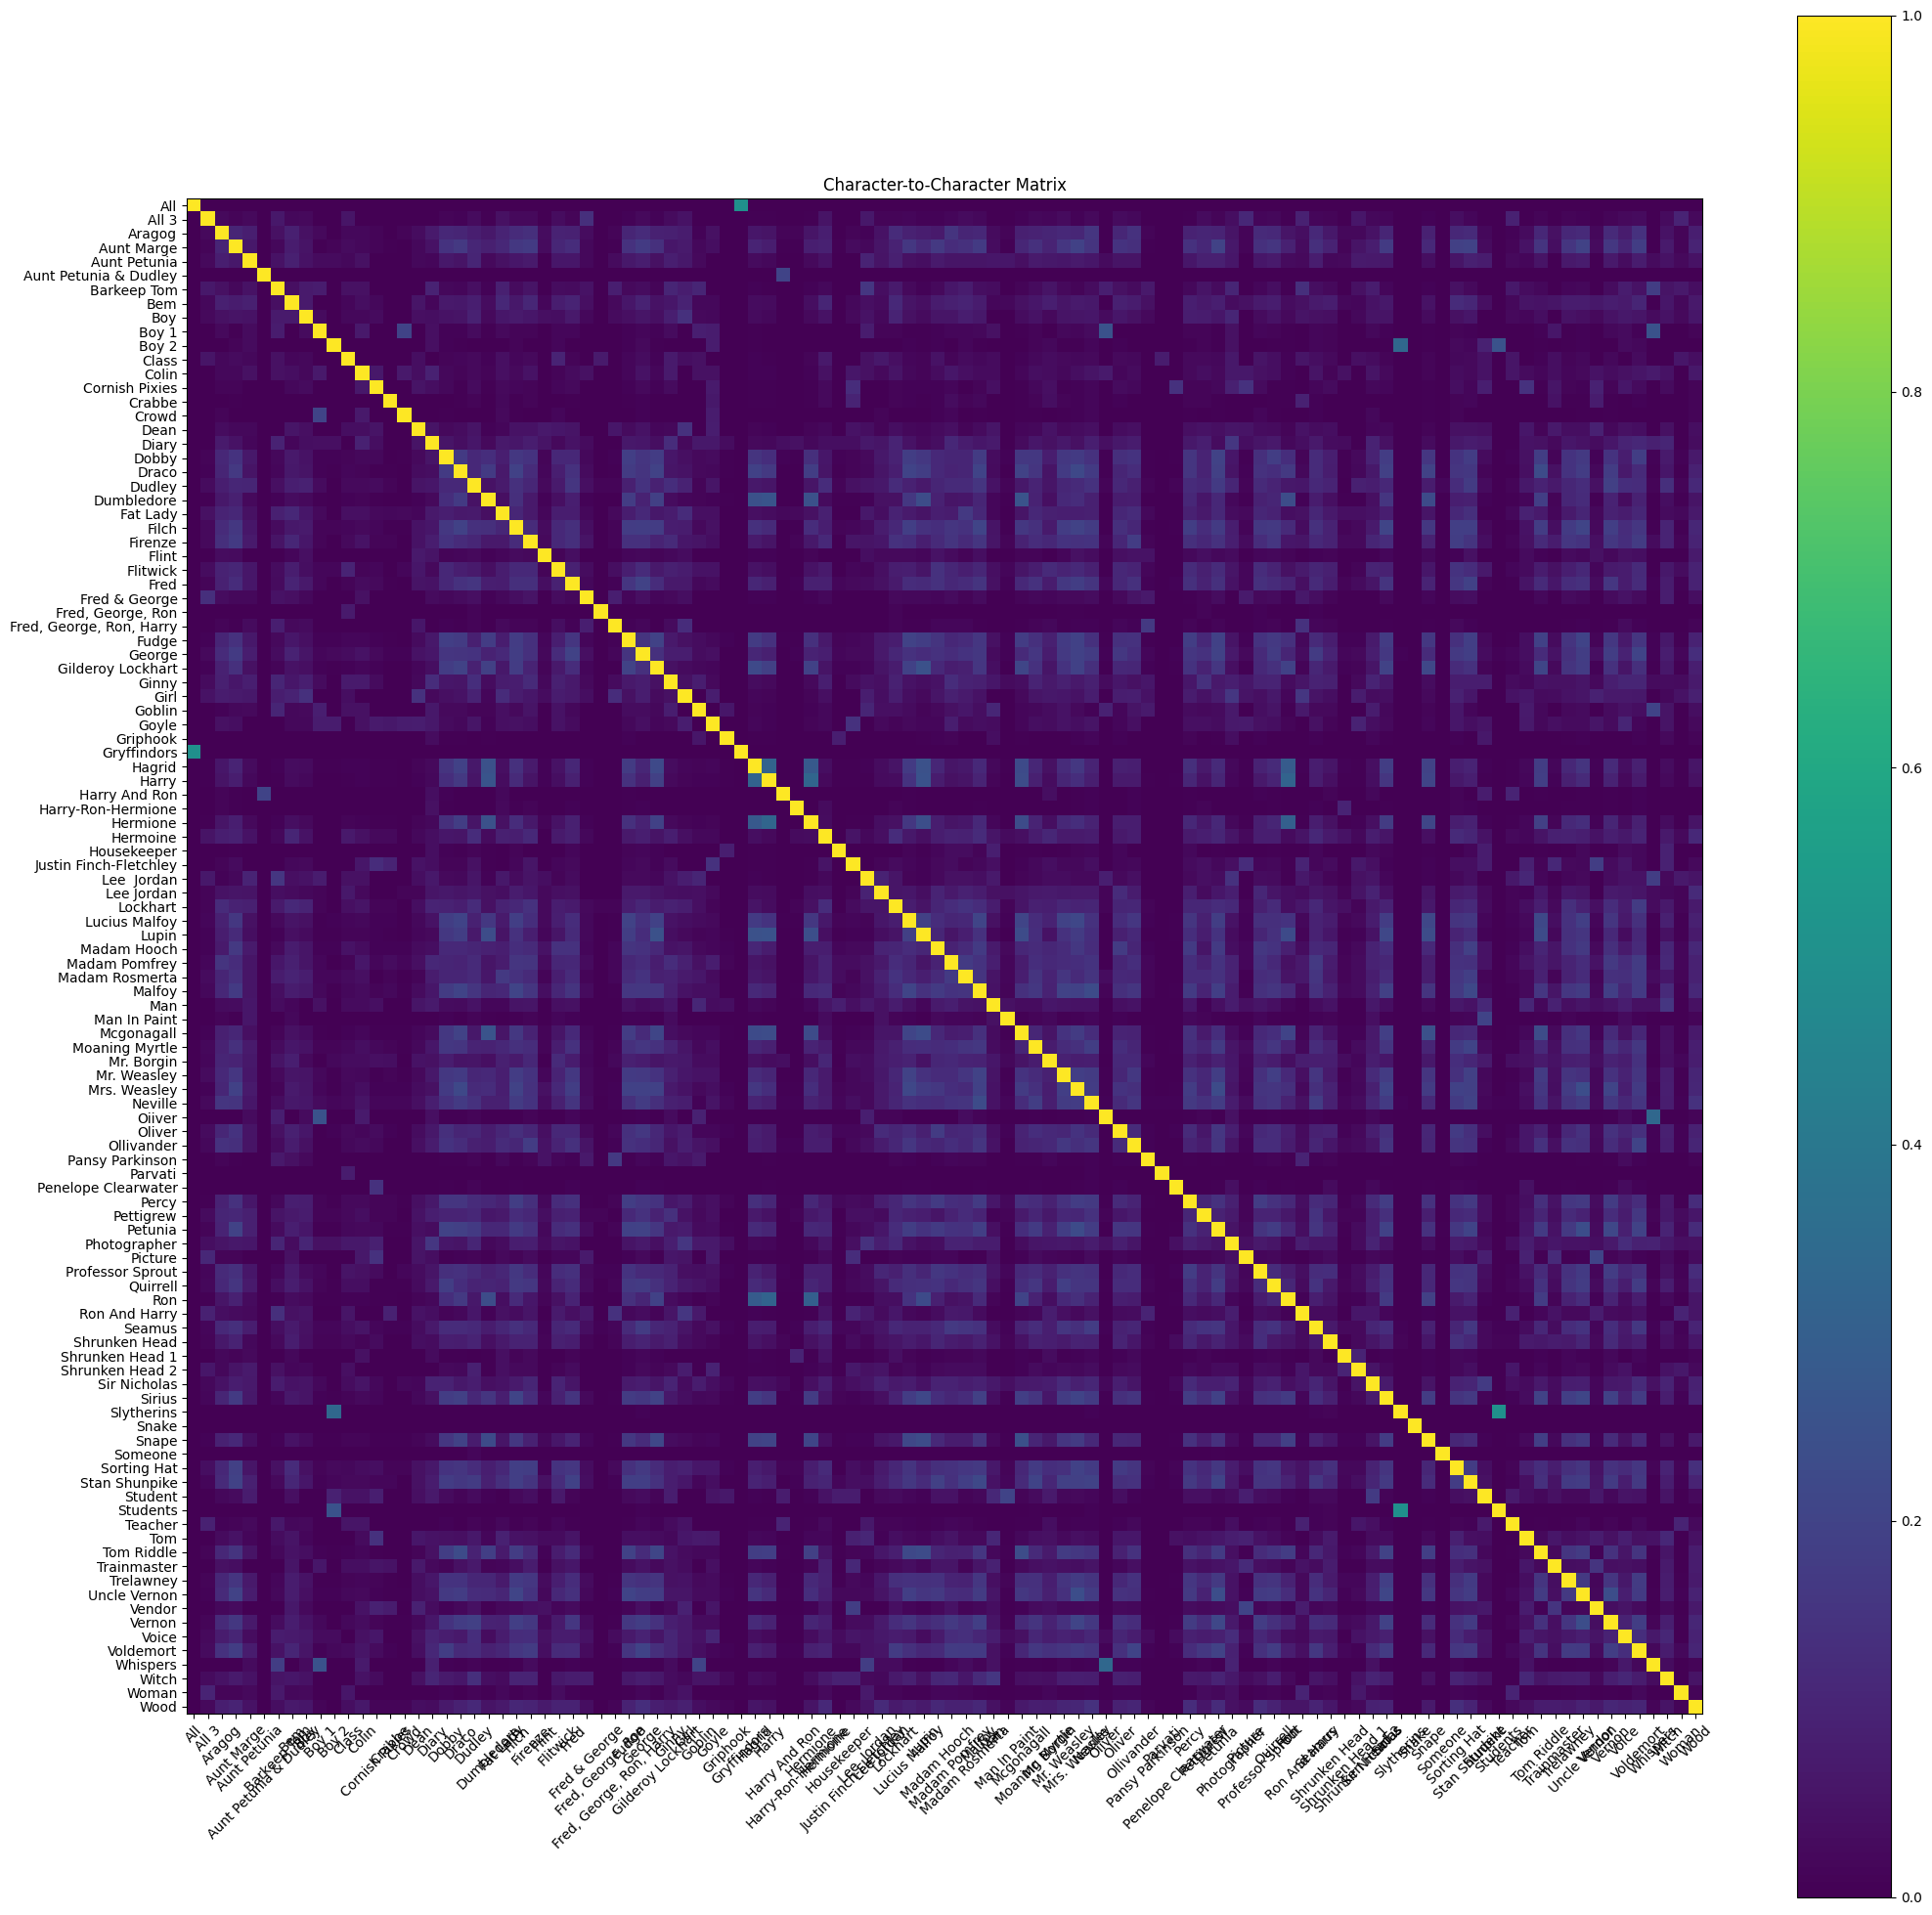

              All     All 3    Aragog  Aunt Marge  Aunt Petunia  \
All           1.0  0.000000  0.000000    0.000000      0.000000   
All 3         0.0  1.000000  0.023529    0.014925      0.026316   
Aragog        0.0  0.023529  1.000000    0.104712      0.085714   
Aunt Marge    0.0  0.014925  0.104712    1.000000      0.065359   
Aunt Petunia  0.0  0.026316  0.085714    0.065359      1.000000   
...           ...       ...       ...         ...           ...   
Voldemort     0.0  0.030000  0.141026    0.182292      0.074380   
Whispers      0.0  0.000000  0.000000    0.000000      0.029412   
Witch         0.0  0.028571  0.047170    0.073826      0.050000   
Woman         0.0  0.100000  0.011765    0.015038      0.027027   
Wood          0.0  0.026667  0.085714    0.098361      0.050505   

              Aunt Petunia & Dudley  Barkeep Tom       Bem       Boy  \
All                             0.0     0.000000  0.000000  0.000000   
All 3                           0.0     0.062500  0

In [91]:
similarity_df = characterToCharacterMatrix(combined_sentences['Character'], combined_sentences['Sentence'])

In [92]:
mostCommonPairs(combined_sentences['Character'], similarity_df)

Most Common Pairs:
All and Gryffindors: 0.5 common words
Gryffindors and All: 0.5 common words
Slytherins and Students: 0.5 common words
Students and Slytherins: 0.5 common words
Boy 2 and Slytherins: 0.3333333333333333 common words
Oiiver and Whispers: 0.3333333333333333 common words
Slytherins and Boy 2: 0.3333333333333333 common words
Whispers and Oiiver: 0.3333333333333333 common words
Harry and Hermione: 0.32428355957767724 common words
Hermione and Harry: 0.32428355957767724 common words
Harry and Ron: 0.31948640483383683 common words
Ron and Harry: 0.31948640483383683 common words
Hagrid and Harry: 0.3178963893249607 common words
Harry and Hagrid: 0.3178963893249607 common words
Hermione and Ron: 0.30101180438448566 common words
Ron and Hermione: 0.30101180438448566 common words
Hagrid and Ron: 0.28596491228070176 common words
Ron and Hagrid: 0.28596491228070176 common words
Hagrid and Hermione: 0.2792714657415438 common words
Hermione and Hagrid: 0.2792714657415438 common words

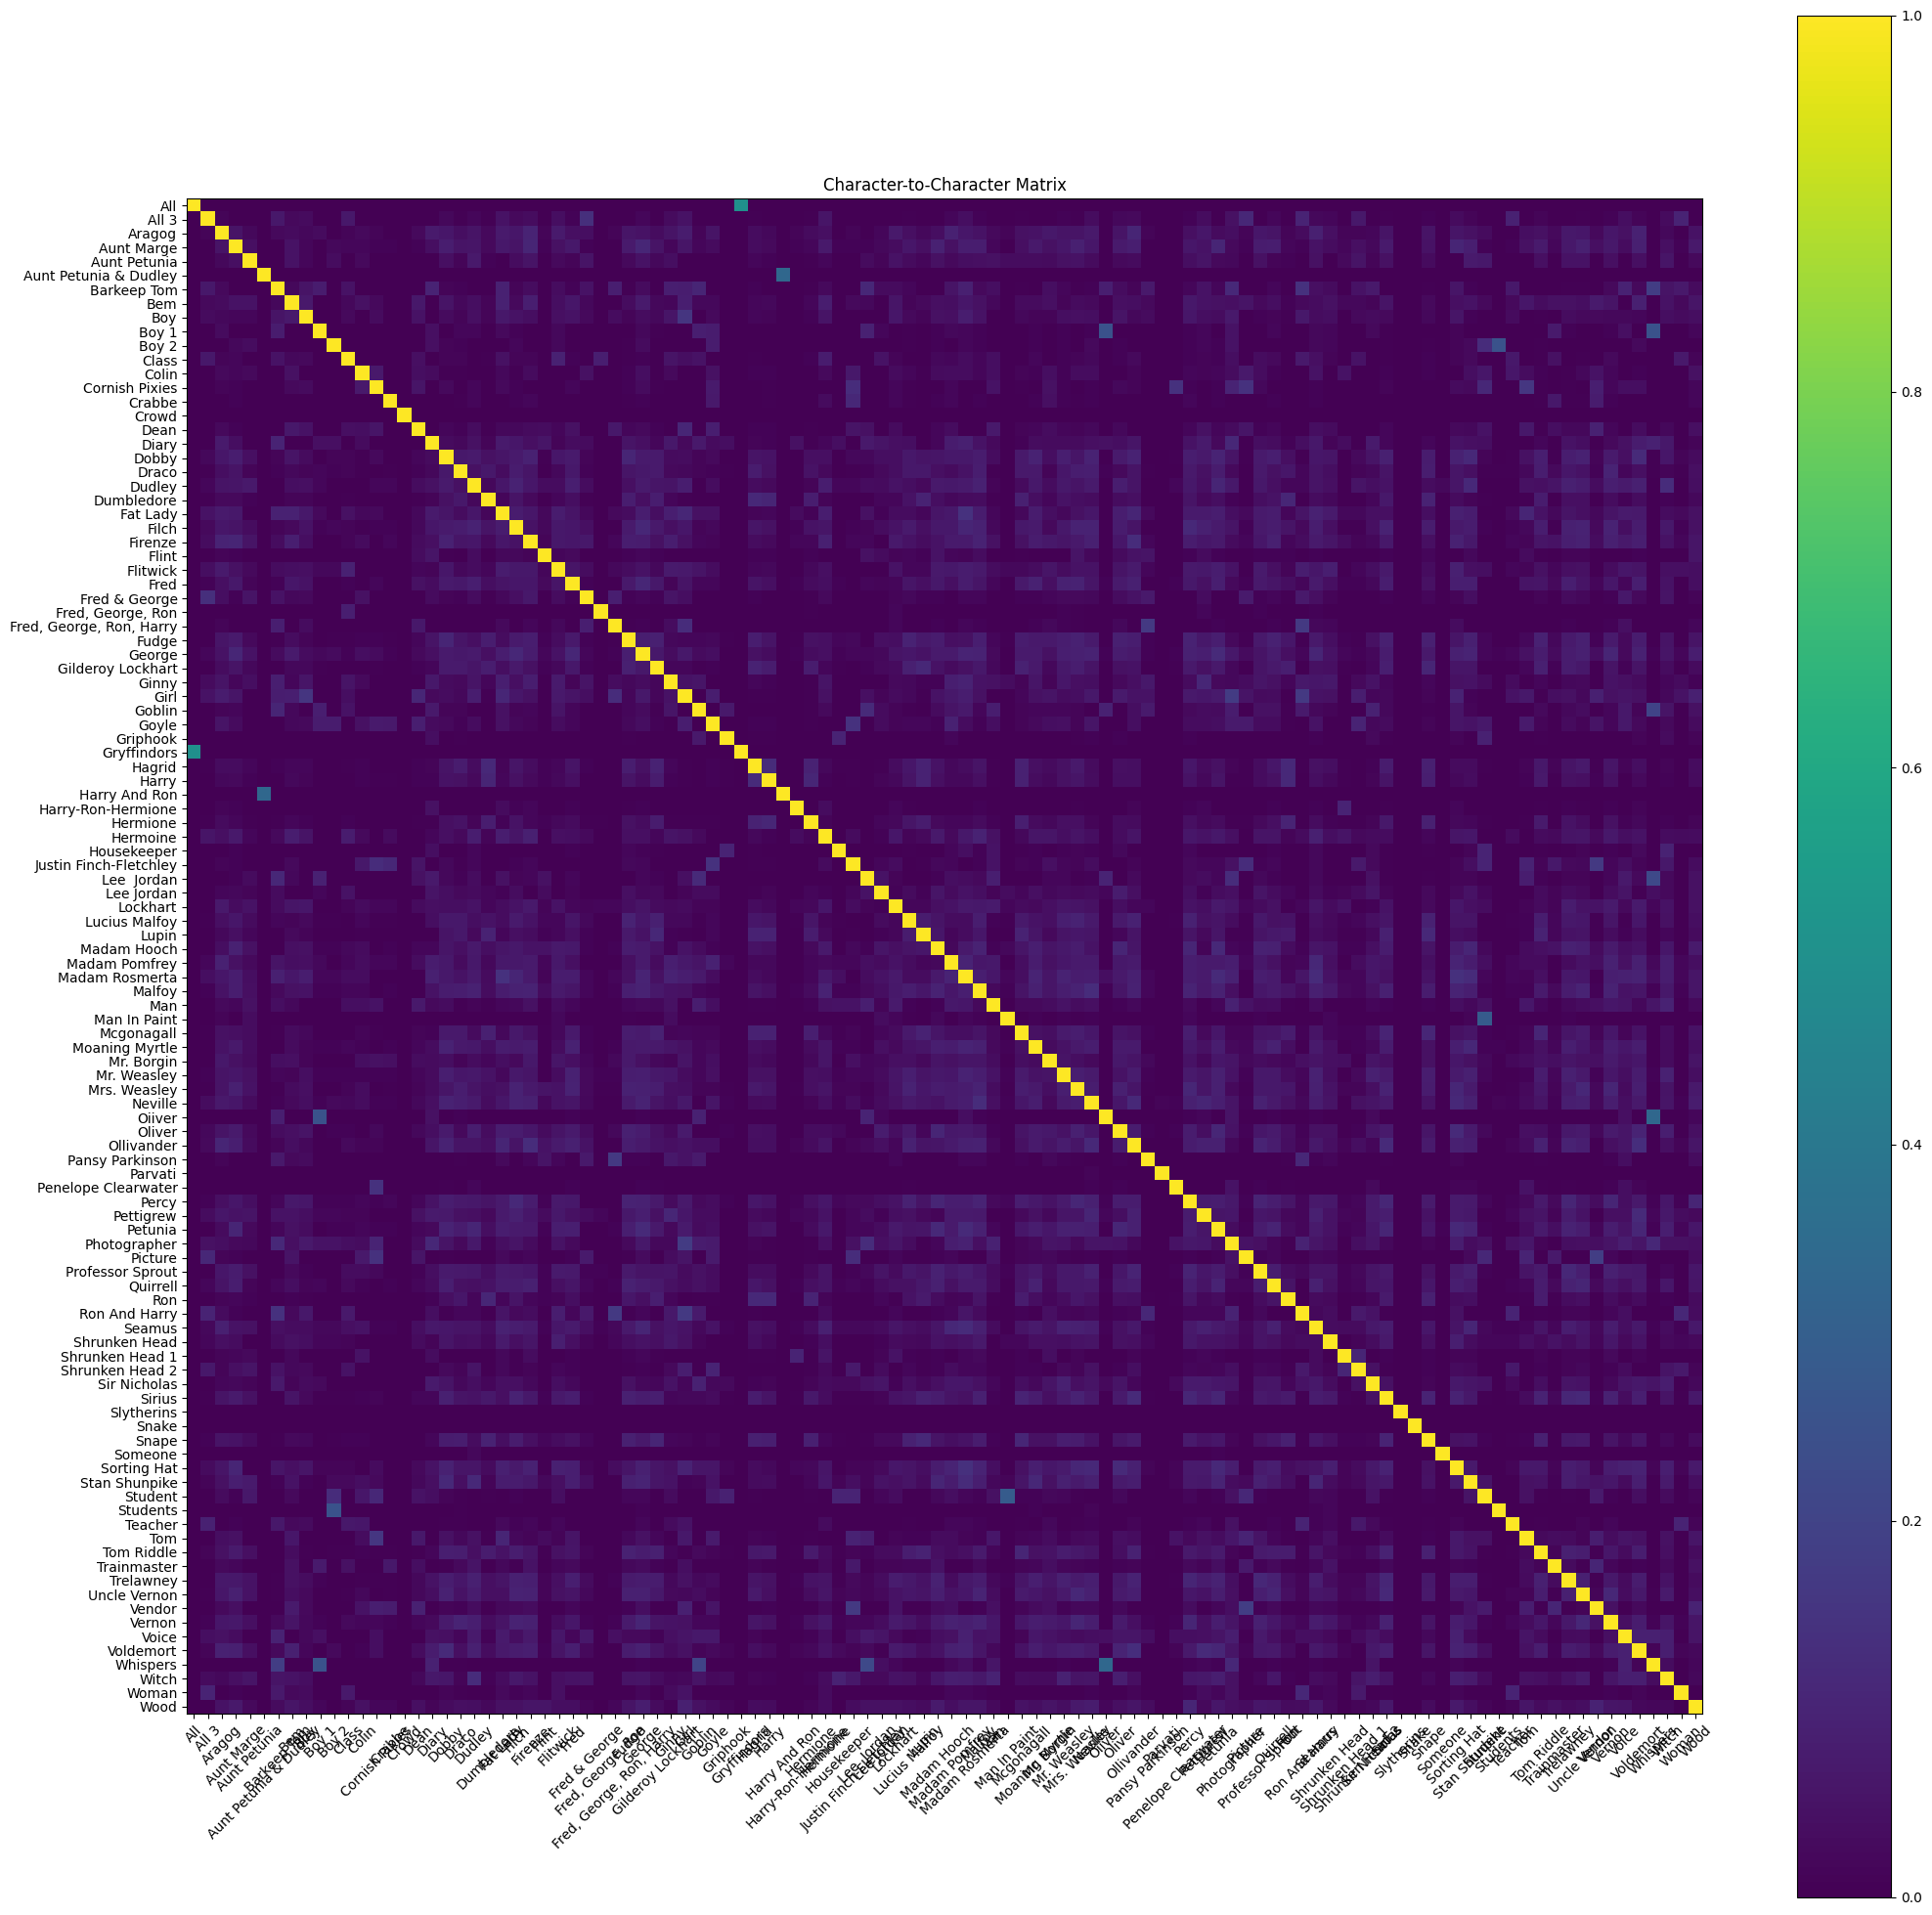

              All     All 3    Aragog  Aunt Marge  Aunt Petunia  \
All           1.0  0.000000  0.000000    0.000000      0.000000   
All 3         0.0  1.000000  0.013514    0.000000      0.000000   
Aragog        0.0  0.013514  1.000000    0.051282      0.021053   
Aunt Marge    0.0  0.000000  0.051282    1.000000      0.042373   
Aunt Petunia  0.0  0.000000  0.021053    0.042373      1.000000   
...           ...       ...       ...         ...           ...   
Voldemort     0.0  0.012346  0.090226    0.089172      0.040000   
Whispers      0.0  0.000000  0.000000    0.000000      0.000000   
Witch         0.0  0.029412  0.020833    0.042017      0.055556   
Woman         0.0  0.100000  0.000000    0.010101      0.000000   
Wood          0.0  0.000000  0.049180    0.069444      0.023529   

              Aunt Petunia & Dudley  Barkeep Tom       Bem       Boy  \
All                             0.0     0.000000  0.000000  0.000000   
All 3                           0.0     0.062500  0

In [98]:
similarity_unique_words_df = characterToCharacterMatrix(combined_sentences['Character'], combined_sentences['words_mentioned_once'])

In [100]:
mostCommonPairs(combined_sentences['Character'], similarity_unique_words_df)

Most Common Pairs:
All and Gryffindors: 0.5 common words
Gryffindors and All: 0.5 common words
Slytherins and Students: 0.5 common words
Students and Slytherins: 0.5 common words
Boy 2 and Slytherins: 0.3333333333333333 common words
Oiiver and Whispers: 0.3333333333333333 common words
Slytherins and Boy 2: 0.3333333333333333 common words
Whispers and Oiiver: 0.3333333333333333 common words
Harry and Hermione: 0.32428355957767724 common words
Hermione and Harry: 0.32428355957767724 common words
Harry and Ron: 0.31948640483383683 common words
Ron and Harry: 0.31948640483383683 common words
Hagrid and Harry: 0.3178963893249607 common words
Harry and Hagrid: 0.3178963893249607 common words
Hermione and Ron: 0.30101180438448566 common words
Ron and Hermione: 0.30101180438448566 common words
Hagrid and Ron: 0.28596491228070176 common words
Ron and Hagrid: 0.28596491228070176 common words
Hagrid and Hermione: 0.2792714657415438 common words
Hermione and Hagrid: 0.2792714657415438 common words